## import libraries

In [1]:
!pip install -e ../

Obtaining file:///home/wankun/workdir/playground/vit_pretrained_pytorch
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pytorch-pretrained-vit
    Found existing installation: pytorch-pretrained-vit 0.0.7
    Uninstalling pytorch-pretrained-vit-0.0.7:
      Successfully uninstalled pytorch-pretrained-vit-0.0.7
  Running setup.py develop for pytorch-pretrained-vit


In [2]:
import os, sys, shutil, json
from pytorch_pretrained_vit import ViT
from torchsummary import summary
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import pandas as pd

## flow control

In [3]:
summarize_model = False
show_image_example = True
regenerate_traffic_data = False

## set up device and load pretrained model

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() == True else torch.device("cpu")
print("Using device:", device)
model = ViT("B_16_imagenet1k", pretrained=True,
            representation_size=768,
            load_repr_layer=True,
           )
model.to(device)
if summarize_model:
    summary(model, input_size=(3,384,384)) # must be 384 for B_16

Using device: cuda:0
repr size None
None True
pre_logits_size 768
Loaded pretrained weights.


## create a small support dataset with predefined labels


In [5]:
# the classes in oki data could be: one-house area, centralized housing(masion etc), public(greenery) area
# first we try 3-way, 3-shot, meaning that we have three images for above classes.
nways = 3
nshots = 3
data_root = "../imgs"
public_set = ["zLW_BVRbb_Vi7qiI1bqvsw.jpg", "_dtiPwWJp7hGyjVzRvn-fQ.jpg", "0eiRArv0qPHxXulFxPCvcg.jpg"]
one_set = ["_V3fRyr4aQWC0cboxU00nQ.jpg", "1HDDK4WHB3ZSHFfI1eyxqg.jpg", "6e9BZHBr7hHw6ukme2Tsfg.jpg"]
center_set = ["1UbKSUbcZ1WWtXqTBktP9w.jpg", "2imsDO2BncseuhMbCYe6Ag.jpg", "2ZzmVyV9HsqIDgfa5lS1eA.jpg"]
ground_truth = {0:"public", 1:"one housing", 2:"centerized housing"}

In [6]:
# define transforms
tsfm = transforms.Compose([transforms.Resize(model.image_size), 
                               transforms.ToTensor(), 
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                              ])

feature vector shape: torch.Size([1, 768])


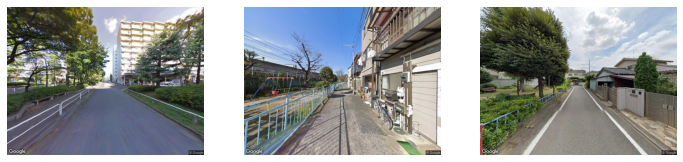

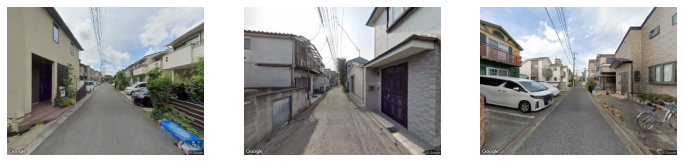

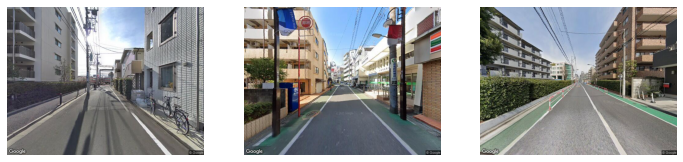

In [7]:
# now we use the pretrained model to extract the feature vectors of these imgs
model.eval() # set model to evaluate mode --> stop tracking gradients
representations = []
showsize = 128, 128
for dataset in [public_set, one_set, center_set]:
    # for each type of the data, calculate the features mean first
    feature_vector = torch.tensor([0]*768, dtype=torch.float).to(device) # 768 dim
    fig = plt.figure(figsize=(12, 12))
    for i, shot in enumerate(dataset):
        img_path = os.path.join(data_root, shot)
        img = Image.open(img_path)
        a=fig.add_subplot(1,nshots,i+1)
        plt.imshow(img)
        plt.axis('off')
        # Preprocess image
        img = tsfm(img).unsqueeze(0)
        with torch.no_grad():
            outputs = model(img.to(device), logits=True).squeeze(0)
        # print(outputs.shape)
        feature_vector += outputs
    # print(feature_vector[0])
    feature_mean = 1/3 * feature_vector
    feature_mean_norm = F.normalize(feature_mean, dim=0)
    representations.append(feature_mean_norm.unsqueeze(0))

    # print(feature_mean_norm.shape)
    # print(feature_vector[0], feature_mean[0], feature_mean_norm[0])
print("feature vector shape:", representations[0].shape)

In [8]:
# the representation_set is [public, one, center]
# now use the same model to extract the feature vector for new data.
def extract_feature_vector(img_path, show=False):
    # feature_vector = torch.tensor([0]*768, dtype=torch.float).to(device) # 768 dim
    img = Image.open(img_path)
    if show:
        fig = plt.figure(figsize=(6,6))
        fig.add_subplot(1,1,1)
        plt.imshow(img)
    # Preprocess image
    img = tsfm(img).unsqueeze(0)
    with torch.no_grad():
        outputs = model(img.to(device), logits=True).squeeze(0)
    return F.normalize(outputs, dim=0)

In [9]:
# test with an example img
pmatrix = torch.empty(3, 768)
pmatrix = torch.cat(representations, dim=0)

## get ready for finetuning with support set

In [11]:
# define finetune data --> support set
X = []
y = []
for fn in public_set:
    img_path = os.path.join(data_root, fn)
    X.append(extract_feature_vector(img_path).unsqueeze(0))
    y.append(0)
for fn in one_set:
    img_path = os.path.join(data_root, fn)
    X.append(extract_feature_vector(img_path).unsqueeze(0))
    y.append(1)     
for fn in center_set:
    img_path = os.path.join(data_root, fn)
    X.append(extract_feature_vector(img_path).unsqueeze(0))
    y.append(2) 
X = torch.cat(X, dim=0).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)
print(X.shape, y.shape)

torch.Size([9, 768]) torch.Size([9])


## init cls head with proper values and configure training options

In [31]:
# the first option is to not let pretrained model weights to float.
# p(x) = softmax(w*x+b) where x is the feature vector from the feature extraction.
fc_w = pmatrix.clone().detach().requires_grad_(True) # this is recommended from pytorch doc
fc_b = torch.zeros((1,fc_w.shape[0]), dtype=torch.float, requires_grad=True)
print(fc_w.requires_grad, fc_b.requires_grad, fc_w.shape, fc_b.shape)

True True torch.Size([3, 768]) torch.Size([1, 3])


In [12]:
# construct loss fn
loss_fn = nn.CrossEntropyLoss()
# create a classification head with given init values
# from feature vector to 3 classes,not that we don't need softmax in torch here.
cls_head = nn.Linear(3, 768)
# load the init values from the representation vectors
with torch.no_grad():
    cls_head.weight = nn.Parameter(fc_w)
    cls_head.bias = nn.Parameter(fc_b)
print(cls_head.bias)
print(cls_head.weight)
# construct optimizer
cls_head.to(device)
lr = 1e-2
optimizer = torch.optim.SGD(cls_head.parameters(), lr=lr)

Parameter containing:
tensor([[0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([[ 0.0130, -0.0477,  0.0885,  ..., -0.0289, -0.0189, -0.0014],
        [ 0.0633, -0.0993,  0.0241,  ..., -0.0398, -0.0587,  0.0046],
        [ 0.0247, -0.0359,  0.0086,  ..., -0.0554, -0.0175,  0.0028]],
       device='cuda:0', requires_grad=True)


In [32]:
## training step (cls head only)

In [33]:
# training loop
# make sure data is on right device
print(X.device)
# set hyperparameters
n_epochs = 2000
for epoch in range(n_epochs):
    pred = cls_head(X)
    # print(pred.shape, y.shape)
    loss = loss_fn(pred, y)
    # reset autograd
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch:", epoch, "Loss:", loss.item())
    # print(pred.shape)

cuda:0
Epoch: 0 Loss: 0.4652303457260132
Epoch: 100 Loss: 0.45190033316612244
Epoch: 200 Loss: 0.43917781114578247
Epoch: 300 Loss: 0.42702803015708923
Epoch: 400 Loss: 0.41541868448257446
Epoch: 500 Loss: 0.4043191969394684
Epoch: 600 Loss: 0.3937012255191803
Epoch: 700 Loss: 0.3835380971431732
Epoch: 800 Loss: 0.37380480766296387
Epoch: 900 Loss: 0.36447790265083313
Epoch: 1000 Loss: 0.3555353879928589
Epoch: 1100 Loss: 0.34695690870285034
Epoch: 1200 Loss: 0.3387230634689331
Epoch: 1300 Loss: 0.33081576228141785
Epoch: 1400 Loss: 0.32321804761886597
Epoch: 1500 Loss: 0.3159140348434448
Epoch: 1600 Loss: 0.3088887631893158
Epoch: 1700 Loss: 0.3021281063556671
Epoch: 1800 Loss: 0.2956188917160034
Epoch: 1900 Loss: 0.2893487811088562


## test and compare "no finetuning" and "finetuning cls head" with few-shot

In [37]:
test_img_path = os.path.join(data_root, "3C9MI5Q1Lpvg8PUJijn_UA.jpg")

tensor([0.3632, 0.3129, 0.3239], device='cuda:0')
public:36.3162%
one housing:31.2907%
centerized housing:32.3931%


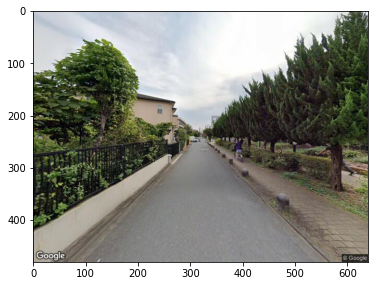

In [38]:
# no finetuning
def make_fewshots_pred_noft(img_path, pmatrix=pmatrix):
    test_vector = extract_feature_vector(img_path, show=True)
    # print(pmatrix.shape)
    prediction = nn.Softmax(dim=0)(torch.matmul(pmatrix, test_vector))
    print(prediction)
    for key, value in ground_truth.items():
        print(f"{value}:{prediction[key]*100:.04f}%")
make_fewshots_pred_noft(test_img_path)

tensor([0.5603, 0.2184, 0.2213], device='cuda:0', grad_fn=<SqueezeBackward0>)
public:56.0313%
one housing:21.8353%
centerized housing:22.1335%


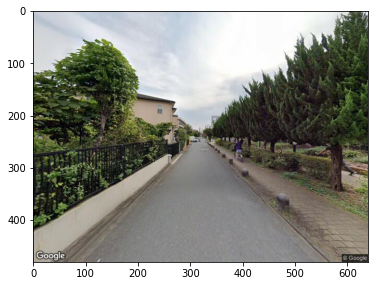

In [39]:
# with cls_head finetuning
def make_fewshots_pred_ft(img_path):
    test_vector = extract_feature_vector(img_path, show=True)
    # print(pmatrix.shape)
    # prediction = nn.Softmax(dim=0)(torch.matmul(pmatrix, test_vector))
    prediction = nn.Softmax(dim=1)(cls_head(test_vector.unsqueeze(0))).squeeze()
    print(prediction)
    for key, value in ground_truth.items():
        print(f"{value}:{prediction[key]*100:.04f}%")
make_fewshots_pred_ft(test_img_path)

## load true labels for the data

In [6]:
labels = pd.read_csv("/mnt/data/projects/wankun01/playground/cv/rawdata/annotations.csv")
labels = labels[["file_name", "category"]]
labels.head()


,file_name,category
0,000_0001.png,0
1,000_0002.png,0
2,000_0003.png,0
3,000_0010.png,0
4,000_0011.png,0


## load labels that model can predict

In [7]:
labels_map = json.load(open('../examples/simple/labels_map.txt'))
labels_map = [labels_map[str(i)] for i in range(1000)]
print(labels_map[0:5])

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark']


## perform single image prediction example

In [16]:
def make_single_prediction(img_path, model, device="cpu", show_image_example=False, feature_extraction=False):
    img = Image.open(img_path)
    if show_image_example:
        img.show()

    # Preprocess image
    tsfm = transforms.Compose([transforms.Resize(model.image_size), 
                               transforms.ToTensor(), 
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                              ])
    img = tsfm(img).unsqueeze(0)
    print("Image shape is:", img.shape)
    model.eval()
    if not feature_extraction:
        with torch.no_grad():
            outputs = model(img.to(device)).squeeze(0)
            print('-----')
            for idx in torch.topk(outputs, k=3).indices.tolist():
                prob = torch.softmax(outputs, -1)[idx].item()
                print('[{idx}] {label:<75} ({p:.2f}%)'.format(idx=idx, label=labels_map[idx], p=prob*100))
    else:
        with torch.no_grad():
            outputs = model(img.to(device), logits=True).squeeze(0)
            print('-----')
            print("Feature size:", outputs[0].shape)
            print("Feature vector from CLS token:", outputs[0])

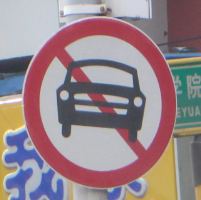

Image shape is: torch.Size([1, 3, 384, 384])
-----
[919] street sign                                                                 (84.90%)
[468] cab, hack, taxi, taxicab                                                    (3.44%)
[734] police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria     (1.86%)


In [17]:
make_single_prediction(train_files[12], model, device=device, show_image_example=show_image_example)

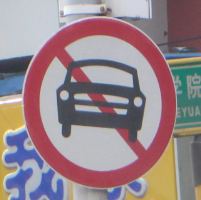

Image shape is: torch.Size([1, 3, 384, 384])
-----
Feature size: torch.Size([768])
Feature vector from CLS token: tensor([-4.8949e-01,  1.7383e-01,  3.9146e+00, -9.5252e+00,  1.5540e+01,
         1.1111e+01, -3.3798e+00,  7.8198e-02,  3.8567e+00,  4.3488e+00,
         8.1906e+00, -1.1974e+01,  5.1124e+00, -6.3481e+00, -6.7030e+00,
        -6.4941e+00,  6.1233e+00,  1.3181e+01,  8.3415e+00, -7.0106e+00,
        -6.6258e+00,  2.5517e+00, -7.6449e+00,  6.2473e+00,  4.5499e+00,
        -1.4978e+01, -6.8154e+00,  8.4583e-02, -6.3796e+00, -8.4274e+00,
         3.8330e+00,  6.3029e+00,  5.6272e+00, -1.2001e+01, -1.7139e+00,
        -6.1034e+00, -7.6705e+00, -1.6690e+00,  3.1559e+00,  2.1467e+00,
         9.8290e+00, -7.5035e+00, -4.2191e+00, -1.3080e+00,  2.1303e+00,
         1.6976e-01, -9.4043e+00, -6.1903e+00, -5.4985e+00,  5.2508e+00,
         8.6961e-01,  6.8728e+00,  1.9246e+00, -5.9319e+00, -5.7305e+00,
         4.1014e+00, -3.5978e+00,  5.1978e+00,  6.2928e+00, -5.5184e+00,
         1

In [18]:
## extract logits before the classification head as feature vector!
make_single_prediction(train_files[12], model, device=device, show_image_example=show_image_example, feature_extraction=True)

## try finetune on the train dataset

In [144]:
## create our dataset 
from  torch.utils.data import Dataset
class TrafficSignDataset(Dataset):
    pass

In [ ]:
model.train() # set to train mode, so all weights become trainable now.
tsfm = transforms.Compose([transforms.Resize(model.image_size), 
                               transforms.ToTensor(), 
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                              ])

for img in train_files:
    img = tsfm(img).unsqueeze(0)

## backup

## (optional) prepare traffic signs images into train and validation folders if needed

In [22]:
def prepare_traffic_train_val(root_path, targ_path, val_size=0.2, seed=42):
    files = glob(root_path)
    n_files = len(files)
    random.seed(seed)
    random.shuffle(files)
    os.makedirs(os.path.dirname(f"{targ_path}/train"), exist_ok=True)
    os.makedirs(os.path.dirname(f"{targ_path}/val"), exist_ok=True)
    # print(files)
    train_files, val_files = [], []
    for f in files[:int(n_files*(1-val_size))]:
        shutil.copy(f, f"{targ_path}/train")
        train_files.append(f)
    for f in files[int(n_files*(1-val_size)):]:
        shutil.copy(f, f"{targ_path}/val")
        val_files.append(f)
    return train_files, val_files

if regenerate_traffic_data:
    train_files, val_files = prepare_traffic_train_val("/mnt/data/projects/wankun01/playground/cv/rawdata/images/*", "/mnt/data/projects/wankun01/playground/cv/ViT-PyTorch/data")

In [ ]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    fig = figure()
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        axis('off')